In [ ]:
import pandas as pd  # For data manipulation and analysis (dataframes, CSVs, etc.)
import numpy as np  # For numerical operations and handling arrays
import seaborn as sns  # For creating attractive and informative statistical graphics
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

from warnings import filterwarnings  # To suppress specific warning messages

# For evaluating machine learning models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential  # For creating linear stack of neural network layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
# Dense: fully connected layer
# Dropout: to prevent overfitting
# Flatten: to flatten 2D arrays to 1D
# Conv2D: convolution layer for feature extraction from images
# MaxPool2D / MaxPooling2D: for downsampling the feature maps
# BatchNormalization: to normalize activations during training

from keras import models  # For building models in a more customizable way
from keras import layers  # For adding layers to the models

import tensorflow as tf  # Main TensorFlow package for deep learning tasks
import os  # For interacting with the operating system (e.g., file paths, directory handling)
import os.path  # For working specifically with file and directory paths
from pathlib import Path  # For object-oriented handling of file system paths

import cv2  # OpenCV: for image processing and computer vision tasks

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# For real-time data augmentation (rotation, flipping, scaling of images during training)

from tensorflow.keras.utils import to_categorical
# To convert labels to one-hot encoded format, useful for classification tasks

from sklearn.model_selection import train_test_split  # To split dataset into training and testing sets

from keras import regularizers  # To apply regularization techniques like L1, L2 to reduce overfitting

from keras.optimizers import RMSprop, Adam  # Optimizers for training the neural network

import glob  # For finding all file paths matching a pattern (useful for batch loading images)

from PIL import Image  # Python Imaging Library: for opening, manipulating, and saving image files

# IGNORING UNNECESSARY WARNINGS

filterwarnings("ignore", category=DeprecationWarning)  # Suppress deprecation warnings
filterwarnings("ignore", category=FutureWarning)  # Suppress future-related warnings
filterwarnings("ignore", category=UserWarning)  # Suppress general user warnings


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")
print("Path to dataset files:", path)

100%|██████████| 84.0M/84.0M [00:00<00:00, 218MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12


In [ ]:
import os
# List all files and folders in the dataset path
files = os.listdir(path)
print("Contents of dataset folder:")
for f in files:
    print(f)

Contents of dataset folder:
yes
pred
no
Br35H-Mask-RCNN


In [ ]:
#File paths for each category of image is created
No_Dataset = Path(path) / "no"
Yes_Dataset = Path(path) / "yes"

In [ ]:
No_Image = list(No_Dataset.glob(r"*.jpg")) #No_Image becomes a list of all .jpg image file paths inside the No_Dataset directory (typically images labeled "no" in classification tasks).
Yes_Image = list(Yes_Dataset.glob(r"*.jpg")) #Yes_Image becomes a list of all .jpg image file paths inside the Yes_Dataset directory (typically images labeled "yes").

In [ ]:
print(f"Number of 'no tumor' images: {len(No_Image)}")
print(f"Number of 'yes tumor' images: {len(Yes_Image)}")

Number of 'no tumor' images: 1500
Number of 'yes tumor' images: 1500


In [ ]:
import random
Yes_No_List = []
for No_JPG in No_Image:
    Yes_No_List.append(("no", No_JPG))
for Yes_JPG in Yes_Image:
    Yes_No_List.append(("yes", Yes_JPG))
random.shuffle(Yes_No_List)

In [ ]:
# Convert to DataFrame for training
Train_Image_Labels = [x[0] for x in Yes_No_List]
Train_Image_Paths = [str(x[1]) for x in Yes_No_List]
Train_Data = pd.DataFrame({
    'JPG': Train_Image_Paths,
    'TUMOR_CATEGORY': Train_Image_Labels
})

In [ ]:
print(len(Train_Data))

3000


In [ ]:
#Pre-processing#

In [ ]:
#Handle missing values or invalid paths
import os
# Remove rows with missing image paths or labels
Train_Data.dropna(inplace=True)
# Remove any rows where the image path doesn't exist
Train_Data = Train_Data[Train_Data['JPG'].apply(os.path.exists)].reset_index(drop=True)
print(len(Train_Data))

3000


In [ ]:
#Split the Data (70-20-10): Train / Validation / Test
from sklearn.model_selection import train_test_split
# Step 1: Train + Temp (temp will be split into val + test)
train_df, temp_df = train_test_split(Train_Data, test_size=0.3, stratify=Train_Data['TUMOR_CATEGORY'], random_state=42)
# Step 2: Validation + Test (50% of 30% = 15% each → total 20-10)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['TUMOR_CATEGORY'], random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 2100 images
Validation set: 600 images
Test set: 300 images


In [ ]:
#Resizing, Grayscale, Normalization, Augmentation (only for training)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Defining image size
IMG_SIZE = (128, 128)
# Training generator (with augmentation)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True #skipping th verical flip as it can produce unrealistic version of the image
    )
# Validation and test generators (no augmentation)
val_test_gen = ImageDataGenerator(rescale=1./255)
# Flow from DataFrames
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='JPG',
    y_col='TUMOR_CATEGORY',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True)
val_data = val_test_gen.flow_from_dataframe(
    val_df,
    x_col='JPG',
    y_col='TUMOR_CATEGORY',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False)
test_data = val_test_gen.flow_from_dataframe(
    test_df,
    x_col='JPG',
    y_col='TUMOR_CATEGORY',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False)

Found 2100 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [ ]:
#PHASE#02	 Model Design and Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras
def build_model():
# Create a Sequential model
  model = keras.models.Sequential([

    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation function, input shape (150,150,3)-->height and width of input image
    keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', input_shape=(128, 128, 1), activation='relu'),

    # Batch Normalization layer to normalize activations and improve training speed and stability
    keras.layers.BatchNormalization(),

    # MaxPooling layer to reduce the spatial dimensions of the image (2x2 pool size)
    keras.layers.MaxPooling2D(2, 2),

    # Dropout layer with 20% probability of dropping units to prevent overfitting
    keras.layers.Dropout(0.2),

    # Second convolutional layer: 64 filters, 3x3 kernel, ReLU activation function
    keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'),

    # Batch Normalization layer again for stabilizing the training
    keras.layers.BatchNormalization(),

    # MaxPooling layer to further reduce the image size
    keras.layers.MaxPooling2D(2, 2),

    # Third convolutional layer: 128 filters, 3x3 kernel, ReLU activation function
    keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu'),

    # Batch Normalization for stable and faster training
    keras.layers.BatchNormalization(),

    # MaxPooling layer to reduce image size further
    keras.layers.MaxPooling2D(2, 2),

    # Dropout layer with 30% probability to prevent overfitting
    keras.layers.Dropout(0.3),

    # Fourth convolutional layer: 256 filters, 3x3 kernel, ReLU activation function
    keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu'),

    # Batch Normalization for faster convergence
    keras.layers.BatchNormalization(),

    # MaxPooling layer to reduce image size further
    keras.layers.MaxPooling2D(2, 2),

    # Dropout layer with 40% probability to prevent overfitting
    keras.layers.Dropout(0.4),

    # Flatten layer to convert the 2D matrix output of the last convolutional layer into a 1D vector
    keras.layers.Flatten(),

    # Fully connected layer with 128 units and ReLU activation function
    keras.layers.Dense(128, activation='relu'),

    # Dropout layer with 50% probability to further reduce overfitting
    keras.layers.Dropout(0.5),

    # Output layer: 1 unit (for binary classification), sigmoid activation to output probability (0 or 1)
    keras.layers.Dense(1, activation='sigmoid'),
    ])
  return model

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,649 (7.61 MB)

 Trainable params: 1,994,689 (7.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Model with Adam
modelAdam = build_model()
modelAdam.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model with SGD
modelSGD = build_model()
modelSGD.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Model with RMSprop
modelRMSprop = build_model()
modelRMSprop.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#Training Model with Adam Optimizer
from tensorflow.keras.callbacks import EarlyStopping
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
# Training model with Adam optimizer and EarlyStopping
history_adam = modelAdam.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6711 - loss: 1.5084 - val_accuracy: 0.7583 - val_loss: 0.5799
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7792 - loss: 0.4885 - val_accuracy: 0.7667 - val_loss: 0.6010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8295 - loss: 0.4098 - val_accuracy: 0.7133 - val_loss: 0.8594
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8319 - loss: 0.3749 - val_accuracy: 0.8167 - val_loss: 0.4728
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8445 - loss: 0.3695 - val_accuracy: 0.8367 - val_loss: 0.3718
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8385 - loss: 0.3874 - val_accuracy: 0.7867 - val_loss: 0.4976
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8529 - loss: 0.3352 - val_accuracy: 0.8650 - val_loss: 0.3072
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8887 - loss: 0.2834 - val_accuracy: 0.8550 - v

In [ ]:
#Training Model with SGD Optimizer
from tensorflow.keras.callbacks import EarlyStopping
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
# Training model with SGD optimizer and EarlyStopping
history_sgd = modelSGD.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6413 - loss: 1.2208 - val_accuracy: 0.6650 - val_loss: 0.6263
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7316 - loss: 0.5493 - val_accuracy: 0.7150 - val_loss: 0.6087
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6996 - loss: 0.5788 - val_accuracy: 0.6950 - val_loss: 0.5919
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7382 - loss: 0.5326 - val_accuracy: 0.8083 - val_loss: 0.5021
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7625 - loss: 0.5054 - val_accuracy: 0.7933 - val_loss: 0.4588
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7128 - loss: 0.5228 - val_accuracy: 0.7167 - val_loss: 0.5365
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7805 - loss: 0.4707 - val_accuracy: 0.8017 - val_loss: 0.4477
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7452 - loss: 0.5712 - val_accuracy: 0.8367 - v

In [ ]:
#Training Model with RMSprop Optimizer
from tensorflow.keras.callbacks import EarlyStopping
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
# Training model with RMSprop optimizer and EarlyStopping
history_rmsprop = modelRMSprop.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6451 - loss: 1.7322 - val_accuracy: 0.7433 - val_loss: 0.5127
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7505 - loss: 0.5667 - val_accuracy: 0.7700 - val_loss: 0.4920
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7896 - loss: 0.4991 - val_accuracy: 0.7800 - val_loss: 0.4734
Epoch 4/50
 5/66 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8363 - loss: 0.3676

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7815 - loss: 0.4786 - val_accuracy: 0.8283 - val_loss: 0.3931
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8180 - loss: 0.4017 - val_accuracy: 0.7983 - val_loss: 0.3914
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8285 - loss: 0.3941 - val_accuracy: 0.7767 - val_loss: 0.5230
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8470 - loss: 0.3698 - val_accuracy: 0.8400 - val_loss: 0.3198
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8687 - loss: 0.3398 - val_accuracy: 0.8500 - val_loss: 0.3159
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8791 - loss: 0.3016 - val_accuracy: 0.9083 - val_loss: 0.2331
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8810 - loss: 0.3136 - val_accuracy: 0.8817 - val_loss: 0.2987
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8970 - loss: 0.2580 - val_accuracy: 0.8750 - val_loss: 

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step
              precision    recall  f1-score   support

          no       0.92      0.91      0.91       150
         yes       0.91      0.92      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

AUC Score: 0.9715111111111111
Confusion Matrix:
 [[136  14]
 [ 12 138]]


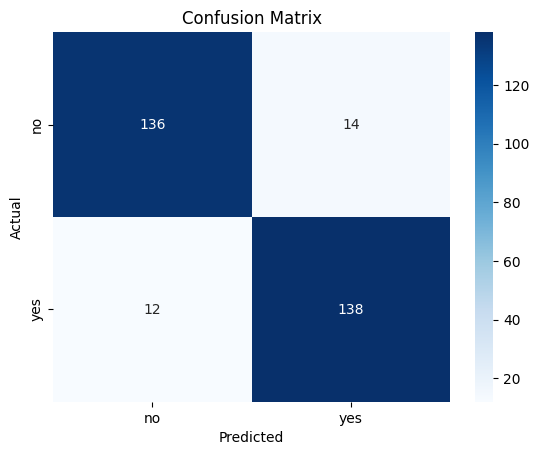

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step
              precision    recall  f1-score   support

          no       0.92      0.88      0.90       150
         yes       0.88      0.92      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

AUC Score: 0.9568666666666666
Confusion Matrix:
 [[132  18]
 [ 12 138]]


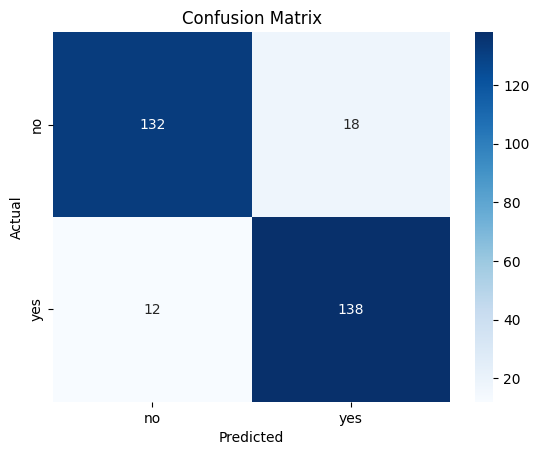

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step
              precision    recall  f1-score   support

          no       0.93      0.85      0.89       150
         yes       0.86      0.93      0.90       150

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300

AUC Score: 0.9713777777777778
Confusion Matrix:
 [[128  22]
 [ 10 140]]


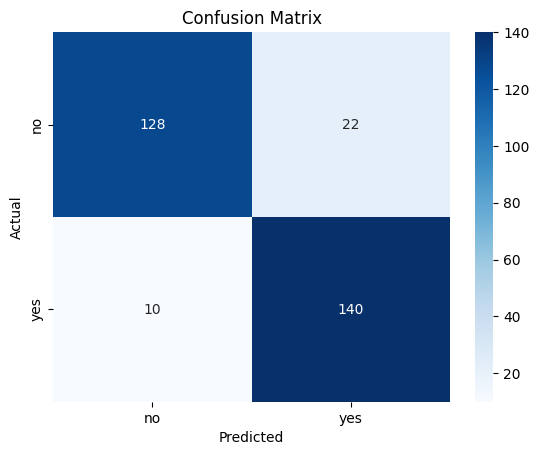

In [ ]:
#Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, test_data):
    # Predict probabilities and convert to class labels
    y_prob = model.predict(test_data)
    y_pred = (y_prob > 0.5).astype("int32")
    y_true = test_data.classes

    # Classification report
    print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

    # AUC Score
    auc = roc_auc_score(y_true, y_prob)
    print("AUC Score:", auc)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Visualize CM
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate each model
evaluate_model(modelAdam, test_data)
evaluate_model(modelSGD, test_data)
evaluate_model(modelRMSprop, test_data)


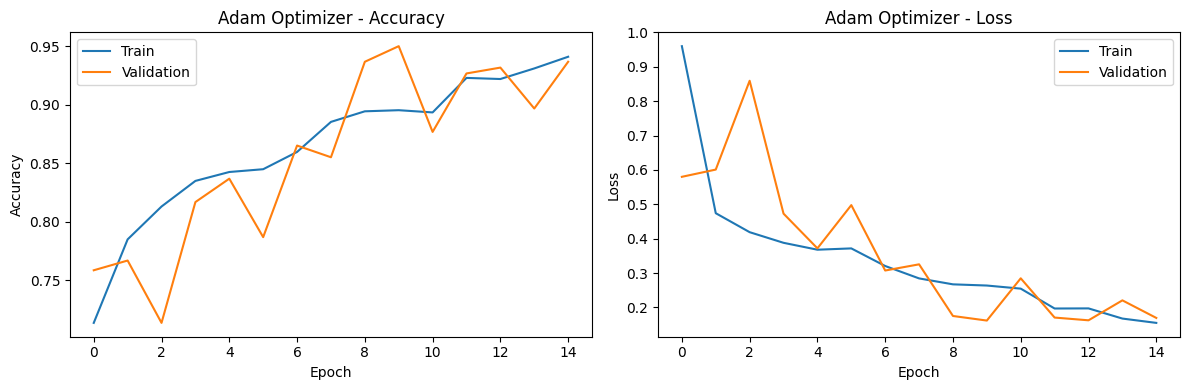

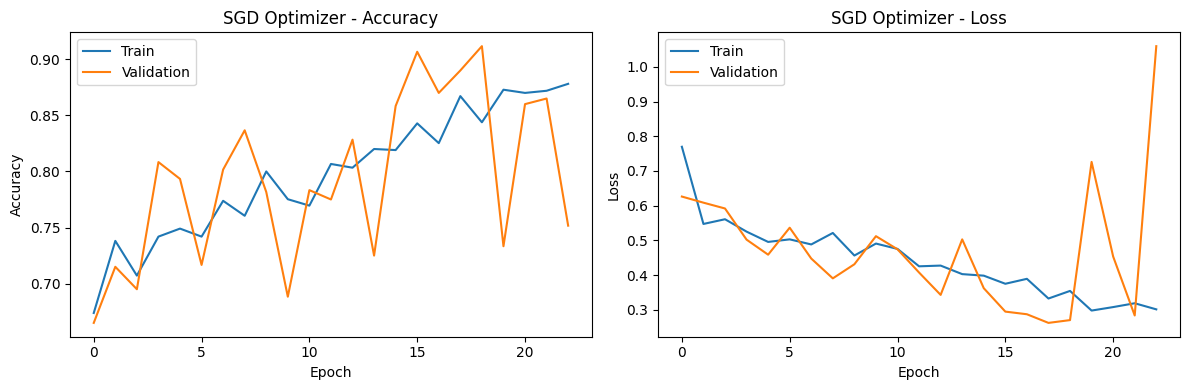

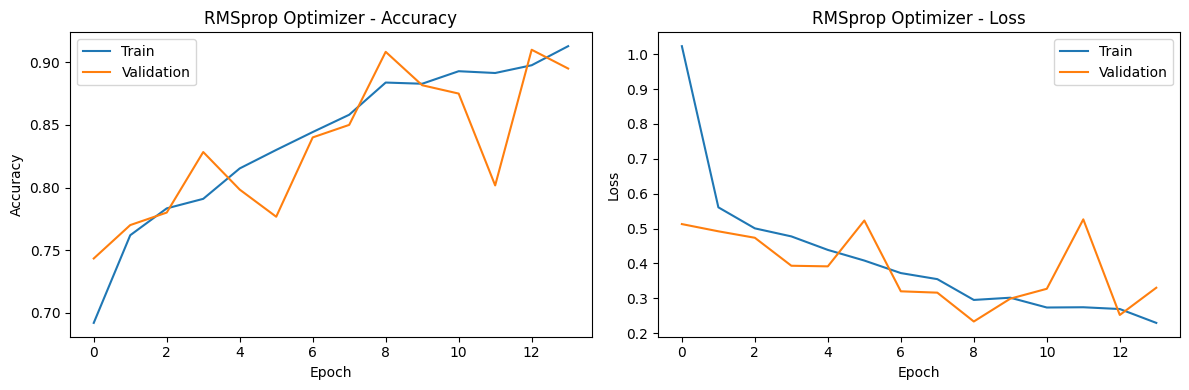

In [ ]:
#Learning Curves
import matplotlib.pyplot as plt

def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example for Adam
plot_learning_curves(history_adam, 'Adam Optimizer')
plot_learning_curves(history_sgd, 'SGD Optimizer')
plot_learning_curves(history_rmsprop, 'RMSprop Optimizer')
